# Regression Analysis of Temporal Processes (Class 8) - AR(2), MA(1), Unit Roots


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from scipy import stats

/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
# Grab the data that we need
GSS = pd.read_csv('trends-gss.csv')
variables = ["cohort", "year", "sex", "age", "marital", "degree"]
sub = GSS[variables].copy()

In [11]:
# recodes
sub['married'] = np.where(sub['marital']==1, 1, 0)
sub['baplus'] = np.where(sub['degree']>=3, 1, 0)
sub['marriedlt50'] = np.where((sub['married']==1) & (sub['age']<50), 1, 0)
sub['degreelt50'] = np.where((sub['baplus']==1) & (sub['age']<50), 1, 0)

# get means by year
by_year = sub.groupby('year', as_index = False).agg("mean")[['year', 'marriedlt50', 'degreelt50']]

In [12]:
# (slide 18)
add_years_df = pd.DataFrame(data = pd.Series([1979, 1981, 1992]), columns = ['year'])
by_year = pd.concat([by_year, add_years_df], sort = False, ignore_index = True)

by_year = by_year.sort_values(['year'])

by_year['year'] = pd.to_datetime(by_year['year'], format = "%Y")
by_year = by_year.set_index('year', drop = False)
by_year['year'] = by_year['year'].dt.year

by_year_ts = by_year.interpolate(method = 'linear')

by_year_ts['marriedlt50_pct'] = by_year_ts['marriedlt50']*100 
by_year_ts['degreelt50_pct'] = by_year_ts['degreelt50']*100 

by_year_ts2 = by_year_ts[by_year_ts['year']<=1992].copy()

Text(0,0.5,'Pct married (under 50 yrs old)')

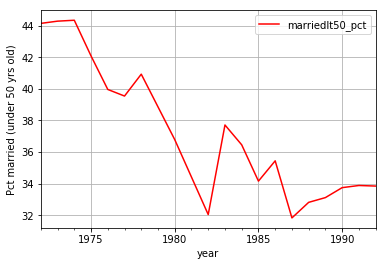

In [5]:
ax = by_year_ts2.loc[:, ['marriedlt50_pct']].plot(xlim = ('1972-01-01', '1992-01-01'), color = 'r', grid = True)
ax.set_ylabel('Pct married (under 50 yrs old)')                                      

Text(0,0.5,'Pct with BA (under 50 yrs old)')

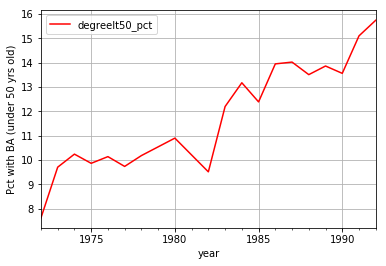

In [28]:
ax = by_year_ts2.loc[:, ['degreelt50_pct']].plot(xlim = ('1972-01-01', '1992-01-01'), color = 'r', grid = True)
ax.set_ylabel('Pct with BA (under 50 yrs old)')                                      

In [6]:
# (slide 23)

cor_vars = ["marriedlt50_pct", "degreelt50_pct", "year"]
cor_dat = by_year_ts2[cor_vars].copy()

cor_dat.corr()

,marriedlt50_pct,degreelt50_pct,year
marriedlt50_pct,1.000000,-0.707896,-0.884607
degreelt50_pct,-0.707896,1.000000,0.929227
year,-0.884607,0.929227,1.000000


### The simplest regression
(slide 24)

In [7]:
lm_married = smf.ols('marriedlt50_pct ~ degreelt50_pct', data = by_year_ts2).fit()
lm_married.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        marriedlt50_pct   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     19.09
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           0.000330
Time:                        15:35:55   Log-Likelihood:                -52.020
No. Observations:                  21   AIC:                             108.0
Df Residuals:                      19   BIC:                             110.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         52.9825      3.681     14.392      0.000      45.277      60.688
degreelt50_pct    -1.3499      0.309     -4.369      0.000      -1.997      -0.703
==============================================================================
Omnibus:                        5.901   Durbin-Watson:                   1.029
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                3.555
Skew:                          -0.815   Prob(JB):                        0.169
Kurtosis:                       4.186   Cond. No.                         66.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

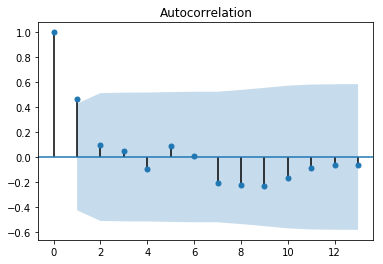

In [8]:
err = lm_married.resid
plot_acf(err, lags = 13);

In [72]:
# (slide 27)
print('LM test = ', durbin_watson(err))

LM test =  1.0290962823656402


In [82]:
# Breusch-Godfrey test

lmtest, pval, fval, f_pval = acorr_breusch_godfrey(lm_married, nlags = 1)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 4.875173991788394
p-value = 0.02724569403599117


### Including the year trend
(slide 28)

In [13]:
lm_married2 = smf.ols('marriedlt50_pct ~ degreelt50_pct + year', data = by_year_ts2).fit()
lm_married2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        marriedlt50_pct   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     64.70
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           6.04e-09
Time:                        16:41:25   Log-Likelihood:                -37.242
No. Observations:                  21   AIC:                             80.48
Df Residuals:                      18   BIC:                             83.62
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2236.3861    292.989      7.633      0.000    1620.840    2851.932
degreelt50_pct     1.5936      0.425      3.749      0.001       0.701       2.487
year              -1.1190      0.150     -7.452      0.000      -1.434      -0.804
==============================================================================
Omnibus:                        0.297   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.862   Jarque-Bera (JB):                0.120
Skew:                          -0.167   Prob(JB):                        0.942
Kurtosis:                       2.839   Cond. No.                     1.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

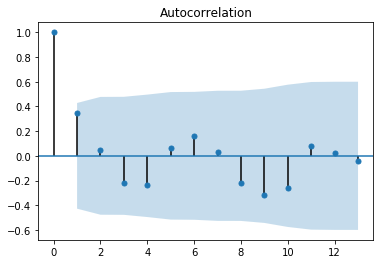

In [8]:
plot_acf(lm_married2.resid, lags = 13);

Text(0,0.5,'error2')

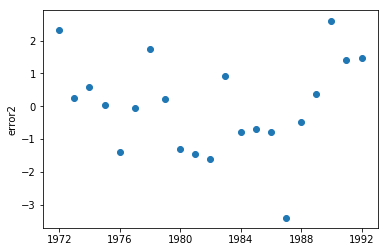

In [41]:
# (slide 33)
import pylab

err = lm_married2.resid
pylab.scatter(err.index, err)
pylab.ylabel('error2')

### Look for autocorrelation in the errors 
(slide 34)

In [14]:
lmtest, pval, fval, f_pval = acorr_breusch_godfrey(lm_married2, nlags = 1)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 3.3030250886517503
p-value = 0.06915242218809134


### Ljung-Box Q 'White Noise test'
(slide 35)

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue, pvalue = acorr_ljungbox(lm_married2.resid, lags = 8)
print('p-values =', pvalue)

p-values = [0.08741084 0.22486504 0.23507116 0.20873534 0.30627855 0.33713237
 0.44329049 0.37575571]


Since all of the p-values are above 0.05, we cannot reject the hypothesis that the residuals are simply "white noise"